In [1]:
# MV/MVP/RP/MD 모형

%matplotlib inline
import matplotlib.pylab as plt
import scipy.optimize as sco
import pandas as pd 
import numpy as np
from numpy.linalg import inv
from matplotlib import font_manager, rc

from dateutil.relativedelta import relativedelta

plt.style.use('seaborn')

FONT_NAME = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=FONT_NAME)

folder_dir = 'C:/data\실습데이터'
DATA_FILE = "KRX300_수정주가_실습.xlsx"

data_wb = pd.ExcelFile(folder_dir + "/" + DATA_FILE)

adj_price = data_wb.parse("Sheet1",  index_col=0)



In [2]:
universe =adj_price[['LG전자','현대차','NAVER','삼성물산','SK텔레콤','KT&G']].loc['2015-01-01':'2022-08-31']
df=universe.resample('M').last().pct_change(1)
print(df.head(6))

                LG전자       현대차     NAVER      삼성물산     SK텔레콤      KT&G
2015-01-31       NaN       NaN       NaN       NaN       NaN       NaN
2015-02-28  0.016447 -0.053097 -0.076812  0.191176 -0.008644 -0.002494
2015-03-31 -0.046926  0.049844  0.015130 -0.077160 -0.048875  0.108750
2015-04-30  0.025467  0.002967 -0.031297  0.060201  0.053216  0.072153
2015-05-31 -0.084437 -0.065089 -0.063079  0.211356 -0.141120  0.013670
2015-06-30 -0.146474 -0.139241  0.041050 -0.075521  0.014202 -0.015560


In [3]:
# W =np.array([0.1,0.3,0.25,0.16,0.09,0.1])# 시가총액합으로 부터 시장 비중 계산

covmat= np.array(df.cov()*12)      # 수익률의 공분산
exret= np.array(df.mean()*12)      #  종목별 기대수익률 
names=['LG전자','현대차','NAVER','삼성물산','SK텔레콤','KT&G']
n_assets = len(names)
rf = .02  # 무위험이자율
pweight=n_assets*[1/n_assets]
weight=np.matrix(pweight)
display(weight,exret,covmat)

matrix([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667]])

array([0.13450663, 0.06624285, 0.11627202, 0.02699865, 0.02811072,
       0.02152712])

array([[ 0.14806583,  0.04850407,  0.03407708,  0.03512789,  0.02417092,
         0.00172856],
       [ 0.04850407,  0.09963468,  0.02299514,  0.01411994,  0.0267349 ,
         0.01162076],
       [ 0.03407708,  0.02299514,  0.09804264,  0.01867757,  0.01104912,
        -0.00060413],
       [ 0.03512789,  0.01411994,  0.01867757,  0.08726477,  0.00907855,
        -0.00317799],
       [ 0.02417092,  0.0267349 ,  0.01104912,  0.00907855,  0.04523314,
         0.01037032],
       [ 0.00172856,  0.01162076, -0.00060413, -0.00317799,  0.01037032,
         0.0341191 ]])

In [56]:

# Tangent Portfolio


def sharpe_ratio(weights,returns,covmat,rf):
    ret=np.sum(returns*weights.T)
    std=np.sqrt(np.dot(weights,np.dot(covmat,weights.T)))
    sharpe =-(ret-rf)/std    # 최소화--> 최대화 되므로 마이너스 붙인다.
    
    return sharpe


gg=sharpe_ratio(weight,exret,covmat,0.02)
print(gg)


[[-0.26817546]]


       allocation
LG전자        34.70
현대차          1.07
NAVER       47.14
삼성물산         0.00
SK텔레콤        0.00
KT&G        17.09


<AxesSubplot:>

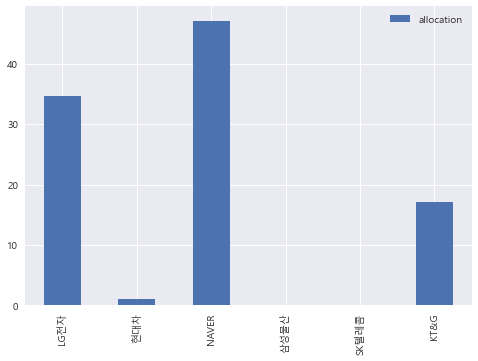

In [57]:

def mean_variance_optimization(returns,cov_mat,rf):
    
    num_assets=len(returns)
    args=(returns,covmat,rf)
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1})
    bounds=[(0,1) for i in range(num_assets)]
    
    result= sco.minimize(sharpe_ratio,num_assets*[1./num_assets,],args=args, method='SLSQP',
                         bounds=bounds,constraints=constraints)
    
    MVO_Allocation =pd.DataFrame(result.x,index=df.columns,columns=['allocation'])  # 종목명 인덱스만 가져다 쓴다.
    
    return round(MVO_Allocation*100,2)

    
ans =mean_variance_optimization(exret,covmat,0.01)
print(ans)
ans.plot.bar()





In [58]:
# Minimum Variance  Portfolio =MVP

def get_portf_vol(weights, returns, cov_mat):
    return np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))

       allocation
LG전자         0.92
현대차          1.06
NAVER       12.48
삼성물산        16.82
SK텔레콤       21.22
KT&G        47.49


<AxesSubplot:>

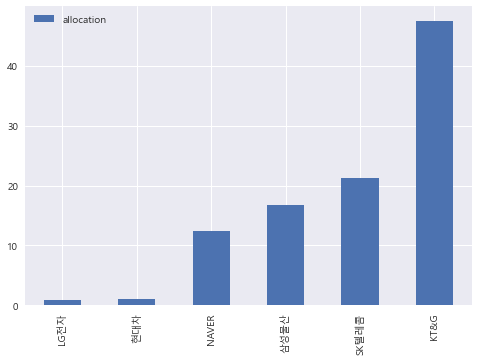

In [50]:


def minimum_variance_optimization(returns,cov_mat):
    
    num_assets=len(returns)
    args=(returns,covmat)
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1})
    bounds=[(0,1) for i in range(num_assets)]
    
    result5= sco.minimize(get_portf_vol,num_assets*[1./num_assets,],args=args, method='SLSQP',
                         bounds=bounds,constraints=constraints)
    
    MVO_Allocation =pd.DataFrame(result5.x,index=df.columns,columns=['allocation'])  # 종목명 인덱스만 가져다 쓴다.
    
    return round(MVO_Allocation*100,2)

    
mnn =minimum_variance_optimization(exret,covmat)
print(mnn)
mnn.plot.bar()


In [8]:

###  Risk parity  ###



weight=pweight  # 초기값은 동일비중으로


def Risk_Contribution(weight,cov_matrix) :
    
    weight =np.array(weight)
    std=np.sqrt(np.dot(weight.T,np.dot(cov_matrix,weight)))
    mrc=np.dot(cov_matrix,weight)/std
    rc=weight*mrc
    
    return rc, std


rcc=Risk_Contribution(weight,covmat) 

print(rcc)








(array([0.02334978, 0.0371745 , 0.0320604 , 0.03892101, 0.02023591,
       0.04339819]), 0.19513979968587294)


In [9]:
def risk_parity_target(weight) :
    
    rc,std=Risk_Contribution(weight,covmat)
    RC_assets=rc
    RC_target=std/len(rc) 
    objective_fun=np.sum(np.square(RC_assets-RC_target.T))
    
    return objective_fun



       allocation
삼성전자        20.38
현대차         14.15
NAVER       15.94
한화          13.70
SK텔레콤       23.23
LG화학        12.61


<AxesSubplot:>

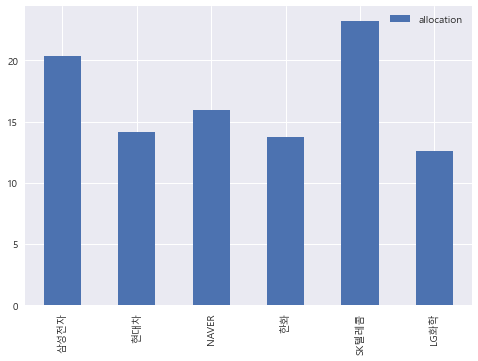

In [10]:
def risk_parity_optimization(cov_matrix):
    
    TOLERANCE= 1e-20
    num_assets=len(cov_matrix)
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1.0},{'type': 'ineq','fun': lambda x: x})  
    result=sco.minimize(risk_parity_target,num_assets*[1./num_assets,],method='SLSQP',
                       constraints=constraints, tol=TOLERANCE)    
    Risk_Parity_Allocation=pd.DataFrame(result.x,index=df.columns,columns=['allocation'])
 
    return  round(Risk_Parity_Allocation*100,2)              

rpo= risk_parity_optimization(covmat)

print(rpo)
rpo.plot.bar()



In [11]:
###  Maximum Diversification

def diversification_ratio(weight, covmat):
    w_vol = np.dot(np.sqrt(np.diag(covmat)), weight.T)
    port_vol = np.sqrt(weight.T @ covmat @ weight)
    diversification_ratio = w_vol/port_vol
    return -diversification_ratio

In [12]:
def Most_Diversified(covmat, lb, ub):
    x0 = np.repeat(1/covmat.shape[1], covmat.shape[1]) 
    lbound  = np.repeat(lb, covmat.shape[1])
    ubound = np.repeat(ub, covmat.shape[1])
    bnds = tuple(zip(lbound, ubound))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1.0})
           
    options = {'ftol': 1e-20, 'maxiter': 800}
    result =sco.minimize(fun = diversification_ratio,
                      x0 = x0,
                      args = covmat,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options,
                      bounds = bnds)
    MD_Allocation=pd.DataFrame(result.x,index=df.columns,columns=['allocation'])
    
    return round( MD_Allocation*100,2)   

       allocation
삼성전자        23.18
현대차         10.94
NAVER       18.15
한화           9.06
SK텔레콤       27.64
LG화학        11.04


<AxesSubplot:>

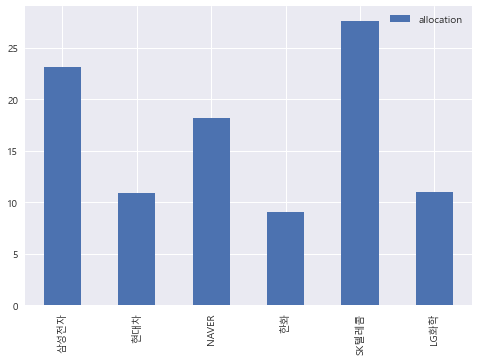

In [46]:

md= Most_Diversified(covmat,0.0,1.0)

print(md)
md.plot.bar()

In [4]:
# Black Litterman  모형

mwt =np.array([0.1,0.3,0.25,0.16,0.09,0.1])  # 시장비중

def equilibrium_expected_return(returns,covmat,market_weight):
    y_returns=returns
    variance=np.dot(market_weight.T,np.dot(covmat,market_weight))
    ra=np.dot(market_weight.T,y_returns)/variance
    mw=np.array([market_weight])
    err=ra*covmat@mw.T
    return err

equi=equilibrium_expected_return(exret,covmat,mwt)

print(equi)

[[0.09357579]
 [0.09453762]
 [0.07907083]
 [0.05486434]
 [0.04033299]
 [0.01499149]]


In [20]:
k=3
def view_P(num_view,num_asset):
     P=np.zeros([num_view,num_asset])
     return P

print(view_P(k,n_assets))

# pm=np.array([[0, 0, 0, 0, 0, 0],[0,0, 0, 0, 0, 0],[0, 0, 0, 0, 0,0]])  # 전망치 없을 경우
pm=np.array([[0, 0, 0, 1, 0, 0],[1,-1, 0, 0, 0, 0],[0, 0, 1, 0, -0.5,-0.5]])  
print(pm)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[ 0.   0.   0.   1.   0.   0. ]
 [ 1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.  -0.5 -0.5]]


In [21]:
# v_return=[0.00,0.00,0.00]  # 전망치 없을 경우

v_return=[0.02,0.03,0.01]

def view_Q(view_return):
    q=np.array([view_return])
    Q=q.reshape(len(view_return),1)
    return Q

Q=view_Q(v_return)

print(Q)


[[0.02]
 [0.03]
 [0.01]]


In [22]:
tau =1

def omega_matrix(tau,view_P,covmat):
    oa=np.diag(tau*view_P@covmat@view_P.T,k=0)
    omega =np.diag(oa)
    return omega

omega=omega_matrix(tau,pm,covmat)
print(omega)


[[0.08726477 0.         0.        ]
 [0.         0.15069238 0.        ]
 [0.         0.         0.11262086]]


In [23]:
# 최종 전망결합기대수익률

def BL_expected_return(tau,covmat,equilibrium_expected_return,view_P,view_Q,omega_matrix):
   
    
     BL=np.linalg.inv(np.linalg.inv(tau*covmat)+(view_P.T@np.linalg.pinv(omega_matrix)@view_P))\
        @(np.linalg.inv(tau*covmat)@equilibrium_expected_return+(view_P.T@np.linalg.pinv(omega_matrix)@view_Q))
            
     BL_returns=pd.DataFrame(BL, index=df.columns,columns=['BL 기대수익률'])
     return BL_returns


       BL 기대수익률
LG전자   0.095430
현대차    0.084555
NAVER  0.060083
삼성물산   0.037352
SK텔레콤  0.041213
KT&G   0.018474


<AxesSubplot:>

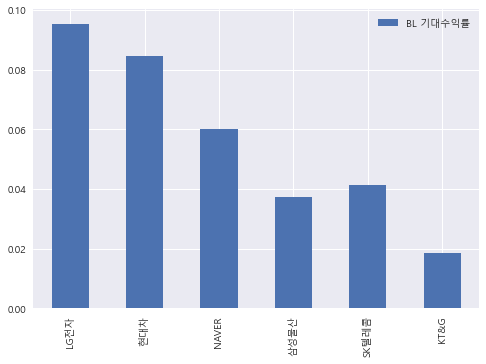

In [24]:
BBL=BL_expected_return(tau,covmat,equi,pm,Q,omega)

print(BBL)
BBL.plot.bar()